
### T1 Data Analysis  

        Sean Keenan, PhD Physics  
        Quantum Memories Group, Heriot-Watt University, Edinburgh  
        2024  

In [1]:
import sys
# Add the parent directory to the system path
sys.path.append('..')

# Now you can import modules or access files from the parent directory
import data_functions as dat
import filter_functions as fil
import fitting_functions as fit
import math_functions as mat
import plotting_functions as plt
import config_file

import os


##### Import Data  
        
        Load data sets & extract time and voltage data


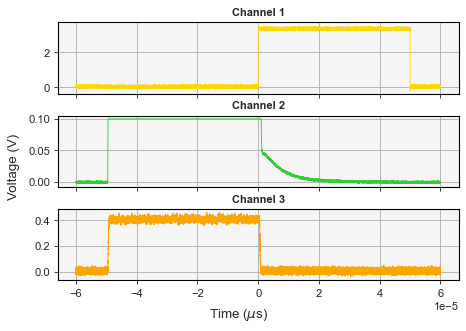

In [2]:
# import config_file
config = config_file.config_params
# path to folders containing T1 data
path = os.path.join(config['root'], config['file'])
# extensions to look for in the folders
exts = config['extensions']
# indexes for data
di = config['data_indexes']
ti = config['trim_indexes']
# make labels from data indexes
labels = {key:di[key] for key in di.keys() if key != 'time'}
# guesses for the T1 times
guess_ref_T1 = config['guess_ref_T1']
guess_T1 = config['guess_T1']
# populate folder and file lists
folder_list, file_list = dat.dir_interogate(path, extensions=exts)
# create dictionary for indexing folders and files
folder_index = dat.make_index_dict(folder_list)
file_index = [dat.make_index_dict(file_sub_list) for file_sub_list in file_list]
# lists of the data paths and metadata (text) paths
data_path_list = dat.search_paths(folder_list, file_list, [exts[0]])
metadata_path_list = dat.search_paths(folder_list, file_list, [exts[1]])
# extract the relevant data from the files
excel_sets = [[dat.open_excel(os.path.join(path, data_path)) for data_path in data_paths] for data_paths in data_path_list]
metadata = [dat.open_text(os.path.join(path, data_path)) for data_paths in metadata_path_list for data_path in data_paths]
# TO DO change this to use dictionary
fluor_duration = [[float(dat.find_numbers(row)) for row in text_file if dat.check_str(["durationFluor"], row.split())] for text_file in metadata] # type: ignore
# populate dictionary for extracting from the metadata
#test = dat.create_dict(os.path.join(path, metadata_path_list[0][0]), delimiter='=')
# plot channel data to check assignment
fig, ax = plt.plot_scope(excel_sets[0][0][:,di['time']], [excel_sets[0][0][:,di['trig']], excel_sets[0][0][:,di['trans']], excel_sets[0][0][:,di['ref']]], titles=labels, multi=True)


##### Fine Tune Trigger Point

        Check the trigger index and adjust if neccesary
        

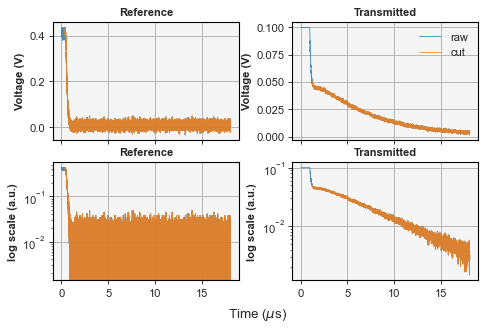

In [3]:
trig_indexes = [[fit.find_trigger(trig_data[:,di['trig']], modifier=0.989) for trig_data in excel_data] for excel_data in excel_sets]
ti['ramp'] = 15000 + trig_indexes[0][0]
# pick an offset
ti['r_off'] = 500
ti['off'] = 1000

# plot transmitted and reference data to check the trigger index
fig, ax = plt.plot_T1_trigger(excel_sets[0][0][:,di['time']]*1e6, [excel_sets[0][0][:,di['ref']], excel_sets[0][0][:,di['trans']]], ti)


##### Process Data  

        Trim the data sets and find initial starting parameters for fitting
        Fit to the data and take average fit values


In [4]:
# find start and stop indexes for the data (saves trying to fit to unnecesary data)
ref_stop_set = [[round(guess_ref_T1*4/(time[:,di['time']][1] - time[:,di['time']][0])) for time in time_lists] for time_lists in excel_sets]
stop_set = [[round(guess_T1*8 /(time[:,di['time']][1] - time[:,di['time']][0])) for time in time_lists] for time_lists in excel_sets]
start_set = [[value + ti['off'] for value in trig_index] for trig_index in trig_indexes]
ref_start_set = [[value + ti['ref_off'] for value in trig_index] for trig_index in trig_indexes]
# create new arrays of cut data using start and stop indexes found
time_sets = [[data[:,di['time']][start:start+stop] for data, start, stop in zip(data_list, start_list, stop_lists)] for data_list, start_list, stop_lists in zip(excel_sets, start_set, stop_set)]
ref_time_sets = [[data[:,di['time']][start:start+stop] for data, start, stop in zip(data_list, start_list, stop_lists)] for data_list, start_list, stop_lists in zip(excel_sets, ref_start_set, ref_stop_set)]
trig_sets = [[data[:,di['trig']][start:start+stop] for data, start, stop in zip(data_list, start_list, stop_lists)] for data_list, start_list, stop_lists in zip(excel_sets, start_set, stop_set)]
trans_sets = [[data[:,di['trans']][start:start+stop] for data, start, stop in zip(data_list, start_list, stop_lists)] for data_list, start_list, stop_lists in zip(excel_sets, start_set, stop_set)]
ref_sets = [[data[:,di['ref']][start:start+stop] for data, start, stop in zip(data_list, start_list, stop_lists)] for data_list, start_list, stop_lists in zip(excel_sets, ref_start_set, ref_stop_set)]
# found initial start params for the fitting functions (minimum and maximum)
list_of_mins = [[min(trans) for trans in trans_lists] for trans_lists in trans_sets]
list_of_maxs = [[max(trans) for trans in trans_lists] for trans_lists in trans_sets]
ref_min_list = [[min(refs) for refs in ref_lists] for ref_lists in ref_sets]
ref_max_list = [[max(refs) for refs in ref_lists] for ref_lists in ref_sets]
# zip the fit data for the reference signal
ref_zip = zip(ref_time_sets, ref_sets, ref_max_list, ref_min_list)
data_zip = zip(time_sets, trans_sets,list_of_maxs,list_of_mins)
# fit to the reference data and average the fit
ref_fit_sets = [[fit.fit_exp_decay(time, ref, params=(max_value, guess_ref_T1, min_value)) for time, ref, max_value, min_value in zip(time_set, ref_set, max_set, min_set)] for time_set, ref_set, max_set, min_set in ref_zip]
ref_fit_avg = [mat.average_arrays(ref_list) for ref_list in ref_fit_sets]
# fit to the transmitted data and average the fit
data_fit_sets = [[fit.fit_exp_decay(time, trans, params=(max_value, guess_T1, min_value)) for time, trans, max_value, min_value in zip(time_set, trans_set, max_set, min_set)] for time_set, trans_set, max_set, min_set in data_zip]
data_fit_avg = [mat.average_arrays(data_list) for data_list in data_fit_sets]

c:\Users\keena\Documents\University\PhD\Code\Lifetime\T1\..\fitting_functions.py:208: OptimizeWarning: Covariance of the parameters could not be estimated
  fit, success = curve_fit(exp_decay, x, y, p0=params, method=meth, bounds=lims)


In [5]:
keys = ['I0', 'T1', 'y0', 'dI0', 'dT1', 'dy0']

fit_data = {}
for duration, data_fit in zip(fluor_duration, data_fit_avg):
    duration_dict = {}
    for key, value in zip(keys, data_fit.flatten().tolist()):
            duration_dict[key] = value
    # After populating duration_dict with all key-value pairs, assign it to fit_data
    fit_data[duration[0]] = duration_dict

In [6]:
# TO DO - fix this so i can save the data
dat.write_json(config['file'] + '_fit.json', fit_data)

In [7]:
# define HDAWG outputs
basic_HDAWG_params = {606: 1,
                      'cp': 3,
                      'sp': 4,
                      'trig_in': 0,
                      'trig_out': 0,
                      'trig_read': 1,
                      'sequence_delay': 1E-3}

# Pit Pulse Parameters
pit_params = {'no_pulses': 280,
              'f_0': 250E6,
              'amplitude': 0.12,
              'freq_sweep': 3.5E6,
              'duration': 30E-6,
              'delay': 250E-6}

# Burn Back Parameters
burn_back_params = {'no_pulses': 100,
                    'f_0': 268.45E6,
                    'amplitude': 0.0395,
                    'freq_sweep': 1E6,
                    'duration': 48E-6,
                    'delay': 250E-6}

# AFC Pulse Params
AFC_params = {'no_pulses': 100, 
              'tau': 1E-6,
              'f_0': 268.45E6,
              'amplitude': 0.0395,
              'duration': 48E-6,
              'delay': 250E-6}

delta = 1/AFC_params['tau']
no_teeth = round((4*burn_back_params['freq_sweep'])/delta) + 2
no_holes = no_teeth - 1

AFC_params['delta'] = delta
AFC_params['no_teeth'] = no_teeth
AFC_params['no_holes'] = no_holes

# Control Pulse Params
cp_in_params = {'f_0': 250E6,
                'amplitude': 0.21,
                'duration': 0.6E-6}

cp_out_params = {'f_0': 250E6,
                 'amplitude': 0.21,
                 'duration': 0.6E-6,
                 'width': 0.3E-6}

# Signal Pulse Params
sp_params = {'f_0': 80E6,
             'amplitude': 0.21,
             'duration': 0.6E-6,
             'width': 0.3E-6}

# Heterodyne Pulse Params
hdyne_params = {'f_0': 80E6,
                'amplitude': 0.21,
                'duration': 0.6E-6,}

# Reading Pulse Params
read_params = {'f_0': 250E6,
              'amplitude': 0.015,
              'freq_sweep': 2E6,
              'duration': 30E-6}

# Shuffle Pulse Params
shuffle_params = {'f_0': 250E6,
                  'amplitude': 0.25,
                  'freq_sweep': 10.5E6,
                  'duration': 1000E-6}

# compile parameter dictionary
param_dictionary = {'HDAWG': basic_HDAWG_params,
                    'pit': pit_params,
                    'burn_back': burn_back_params,
                    'AFC': AFC_params,
                    'cp_in': cp_in_params,
                    'cp_out': cp_out_params,
                    'sp': sp_params,
                    'hdyne': hdyne_params,
                    'read': read_params,
                    'shuffle': shuffle_params,
                    'dict_one' : dict_1,
                    'dict_two': dict_2}

NameError: name 'dict_1' is not defined